### MDSI Advanced Machine Learning Applications

**Student: Ivan Cheung**

**Assignment: Kaggle 1**


Model: Logistic Regression (Week 3)

This model was built during week 3 (28/08 - 03/09) by applying a logistic regression.
Improvements in this model from week 2 include:

- Inclusion of AdaBoost Classifier (from model 3)
- Loop through several hypertuning perimeters to evaluate best AUROC scores.

In [126]:
## Import libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder   ## for normalising the feature data
from sklearn.model_selection import train_test_split              ## making test/train splits, for producing AUROC score?
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from joblib import dump
from joblib import load
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sb

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [127]:
# Load train and test data
df = pd.read_csv('../data/raw/train.csv', low_memory=False)
test_df = pd.read_csv('../data/raw/test.csv', low_memory=False)

### Pre-processing:

1) Create preprocessing function:
- Remove unwanted columns
- Fill nulls with '0'

2) Apply preprocessing steps

3) Extract target and player Id columns

In [128]:
## PREPROCESSING FUNCTIONS

## create a function to remove the corrupt columns and return a clean df
def remove_unwanted_cols(df):
    # ftr - no description given, removed from feature analysis
    # yr - player year details are descriptive, need to vectorise in future modelling
    # ht - player height data has been corrupted
    # num - payer number not relevant as a feature
    # pfr - no description given, removed from feature analysis
    # type - metadata field not relevant as a feature
    # year - no longitudinal inclusion for feature modeling

    df_clean = df.drop(["ht", "num", "type" ,"year", "ftr", "pfr", "pick"], axis = 1)    
    ##df_clean = df.drop(["team", "conf", "ht", "yr", "num", "type" ,"year", "ftr", "pfr"], axis = 1)

    return df_clean

## fill null values with 0
## TO IMPROVE: not all columns should be filled with 0. Will need to reveiw this moving forward...
def fillna(df):
    df_clean = df.fillna(0)

    return df_clean

## clean yr column
## Year column acceptable values are: So, Sr, Jr, Fr.
## replace every other value with "Yr-Other" -- this value will be deleted afterwards during OneHotEncoding
def clean_yr(df):
    valid_yr = ('So', 'Sr', 'Jr', 'Fr')
    df['yr'] = df['yr'].apply(lambda x: 'yr_other' if x not in valid_yr else x)
    return df

In [129]:
## Preprocessing dataframe 

# remove unwanted columns, previously identified as corrupt
df_clean = remove_unwanted_cols(df)

# apply placeholder values for nulls
df_clean = fillna(df_clean)

# clean 'yr' values
df_clean = clean_yr(df_clean)

In [130]:
## pop columns into separate lists
target = df_clean.pop('drafted')
player_ids = df_clean.pop('player_id')

#### Feature Engineering

1) Apply Standard Scalar on numerical features

2) Apply OneHotEncoding for categorical features

3) Merge features into single dataframe

4) Apply upsampling to features

5) Add steps to modelling pipeline

In [131]:
## Apply Standard Scalar and OHE (for team name and conference name)
## define the numeric cols and the category cols from the df_clean dataset
num_cols = list(df_clean.select_dtypes('number').columns)
cat_cols = list(set(df_clean.columns) - set(num_cols))

In [132]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
features = ohe.fit_transform(df_clean[cat_cols])

## extract the cat attributes (the team names and conference names) from the training data
attribute_cats = ohe.categories_

In [133]:
numeric_transformer = Pipeline(steps= [("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps= [("encoder", OneHotEncoder(sparse_output=False, categories = attribute_cats,handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)



In [134]:
clf = AdaBoostClassifier(random_state=0, n_estimators=100)
model = imbpipeline(
    steps=[
            ("preprocessor", preprocessor), 
            ("smote", SMOTE()), 
            ("classifier", clf)
        ]
)

#### Modelling Steps:

1) Split training data into train and test set
2) Process training data through the model pipeline

In [135]:
## splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df_clean, target, test_size=0.2, random_state=8)

#### Hyperparameter tuning - AdaBoost

1) Get default parameter values
2) create a set of parameters to evaluate
3) Use GridSearchCV to evalute different hyperparameters.

In [136]:
# get param values
clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 100,
 'random_state': 0}

In [137]:
## create parameter values for evaluation
parameters = {'n_estimators':[100, 200],
              'learning_rate':[0.5,  1, 2]}

In [138]:
## test
parameters = {'n_estimators':[200],
              'learning_rate':[0.5]}

In [139]:
model = imbpipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("smote", SMOTE()) , 
        ("gridsearch", GridSearchCV(clf, param_grid=parameters, scoring='roc_auc', cv = 2, verbose = True))
    ]
    , verbose = True)

In [140]:
## fit data against gridsearch
model.fit(X_train, y_train)

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   0.7s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Pipeline] ........ (step 3 of 3) Processing gridsearch, total=14.8min


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'porpag', 'adjoe',
                                                   'Rec_Rank', 'ast_tov',
                                                   'rimmade', 'rimmade_rimm...
       'SB', 'SC', 'SEC', 'SWAC', 'Slnd', 'Sum', 'WAC', 'WCC', 'ind'],
      dtype=object)],
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['team', 'yr', 'conf'])])),
                ('smote', SMOTE()),
                ('gridsearch',
                 GridSearchCV(cv=2,
                              estimator=AdaBoostClassifier(n_estimators=100,
                                                           random_state=0),
                              param_grid={'learning_rate': [0.5],
                                          'n_estimators': [200]},
                              scoring='roc_auc', verbose=True))],
         verbose=True)

In [141]:
# Save model
dump(model, '../models/model_4.joblib')

print(model.named_steps['gridsearch'].best_params_)
print(model.named_steps['gridsearch'].best_score_)

{'learning_rate': 0.5, 'n_estimators': 200}
0.9997897577134884


In [142]:
results_df = pd.DataFrame(model.named_steps['gridsearch'].cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
0,"{'learning_rate': 0.5, 'n_estimators': 200}",1,0.99979,0.000059


#### Model Analysis:

Using GridSearch best result hyperparameters:

1) Predict target on test set.
2) Generate confusion matrix
3) Generate AUROC score and ROC curve

In [143]:
## Predict on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]


Text(0.5, 23.52222222222222, 'Predicted label')

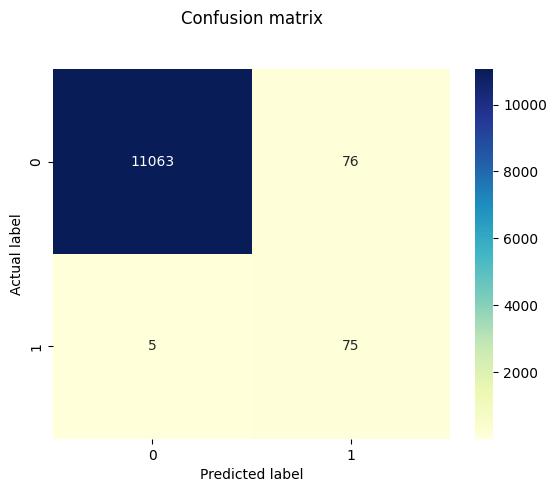

In [144]:
## Confusion Matrix
cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

sb.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [145]:
## Calculate AUROC

auroc = roc_auc_score(y_test, y_pred_proba)
print("AUROC score: ", auroc)

AUROC score:  0.998251638387647


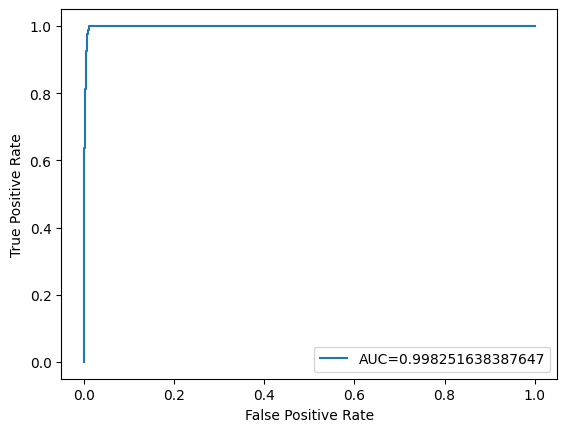

In [146]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
## ROC Curve

plt.plot(fpr, tpr, label="AUC="+str(auroc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#### Predict Target Classification on test data

1) Predict target
2) Save Target as Submission
3) Save model files

In [147]:
##load model if required
if model is None:
    model = load('../models/model_4.joblib')

In [148]:
## Preprocessing and Fitting against pipeline
## pop targets and player num
test_ids = test_df.pop('player_id').to_frame()

## preprocessing steps
test_clean = remove_unwanted_cols(test_df)
test_clean = fillna(test_clean)

In [149]:
# Apply to the pipeline and predict
test_pred = model.predict_proba(test_clean)

# Round predicted values to 2 decimal places
test_pred_drafted = np.round(test_pred[:, 1], 2)

## Attach predictions to player_ids
test_ids['drafted'] = test_pred_drafted

In [150]:
# Save to submission file
test_ids.to_csv('../data/processed/submission.csv', index=False)

In [ ]:
## Save processed files
X_train.tofile('../data/processed/X_train.csv')
X_test.tofile('../data/processed/X_test.csv')
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Save model
dump(clf, '../models/logistic_regression_2.joblib')